# Chapter 4: Influential Classification Tools - ResNet from Keras-App

In the previous [notebook](./ch4_notebook2_resnet_from_scratch.ipynb), we learned how to reimplement a state-of-the-art CNN such as ResNet. However, as discussed in Chapter 4, both TensorFlow and Keras provides well-curated implementations for several standard architectures. Therefore, we will demonstrate in this notebook how to use models from Keras Applications ([https://keras.io/applications](https://keras.io/applications)), choosing once again ResNet-50 applied to the classification of Tiny-ImageNet.

In [1]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt

In [2]:
from tiny_imagenet import (
    tiny_imagenet, _training_augmentation_fn, 
    IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, NUM_CLASSES)

TINY_IMAGENET_ROOT_FOLDER = os.path.expanduser('~/datasets/tiny-imagenet-200/')

NUM_TRAINING_IMAGES = 500 * NUM_CLASSES
NUM_VAL_IMAGES = 50 * NUM_CLASSES
batch_size = 32
num_epochs = 300


## ResNet Instantiation

As explained in the chapter, models provided by Keras through its `applications` package have a standard signature. For this notebook, we will instantiate a ResNet-50 model, with randomly-initialized parameters (we could directly reuse the  weights pre-trained on ImageNet which are provided by Keras, but the point here is to demonstrate how to retrain such a model from scratch).

Note that like in the previous notebook, we resize the Tiny-ImageNet images to 224x224 (to have a pipeline similar to the one used by the ResNet authors in their experiments):

In [4]:
IMG_HEIGHT, IMG_WIDTH = 224, 224

In [5]:
resnet50 = tf.keras.applications.resnet50.ResNet50(
    include_top=True, weights=None, 
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), classes=NUM_CLASSES)
resnet50.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Comparing to the ResNet-50 we implemented ourselves previously, we can notice the architectures are slightly different. Our curious readers can try spotting the differences, c.f. the Keras [sources](https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py) (which are well commented).

## ResNet Usage

To further compare with our simple re-implementation from the previous notebook, we reproduce the same experiment on Tiny-ImageNet. (the rest of the code is thus copy-pasted from the previous experiment - we invite our readers to check there for more detailed comments)

### Preparing the Data

For the input pipelines, we simply reuse the functions we implemented in a previous [notebook](./ch4_notebook_1_data_preparation.ipynb):

In [6]:
train_images, train_labels, class_ids, class_readable_labels = tiny_imagenet(
    phase='train', shuffle=True, batch_size=batch_size, num_epochs=num_epochs, wrap_for_estimator=False,
    augmentation_fn=_training_augmentation_fn, root_folder=TINY_IMAGENET_ROOT_FOLDER,
    resize_to=[IMG_HEIGHT, IMG_WIDTH])

val_images, val_labels, _, _ = tiny_imagenet(
    phase='val', shuffle=False, batch_size=batch_size, num_epochs=None, wrap_for_estimator=False,
    augmentation_fn=None, root_folder=TINY_IMAGENET_ROOT_FOLDER,
    resize_to=[IMG_HEIGHT, IMG_WIDTH])


In [7]:
train_steps_per_epoch = NUM_TRAINING_IMAGES // batch_size
val_steps_per_epoch = NUM_VAL_IMAGES // batch_size

### Training the Network


In [8]:
import functools

# Defining a custom metrics (top-5 accuracy), from a more generic one provided by Keras:
sparse_top_5_categorical_accuracy = functools.partial(
    tf.keras.metrics.sparse_top_k_categorical_accuracy, k=5)
sparse_top_5_categorical_accuracy.__name__ = 'sparse_top_5_categorical_accuracy'

# Defining optimizer and callbacks for the training:
optimizer = tf.keras.optimizers.SGD(momentum=0.9, nesterov=True)

model_dir = './models/resnet_keras_app'
callbacks = [
    # Callback to interrupt the training if the validation loss/metrics stops improving for 15 epochs:
    tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_sparse_categorical_accuracy'),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model, e.g., every 5 epochs:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), period=5)
]

# Finally, compiling and training:
resnet50.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
                 metrics=['sparse_categorical_accuracy', sparse_top_5_categorical_accuracy])
history = resnet50.fit(train_images, train_labels,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
                       validation_data=(val_images, val_labels), validation_steps=val_steps_per_epoch,
                       verbose=1, callbacks=callbacks)

Epoch 1/300
3125/3125 [==============================] - 802s 257ms/step - loss: 5.1959 - sparse_categorical_accuracy: 0.0387 - sparse_top_5_categorical_accuracy: 0.1400 - val_loss: 4.8904 - val_sparse_categorical_accuracy: 0.0387 - val_sparse_top_5_categorical_accuracy: 0.1305
Epoch 2/300
3125/3125 [==============================] - 797s 255ms/step - loss: 4.3086 - sparse_categorical_accuracy: 0.1025 - sparse_top_5_categorical_accuracy: 0.2821 - val_loss: 4.1044 - val_sparse_categorical_accuracy: 0.1259 - val_sparse_top_5_categorical_accuracy: 0.3258
Epoch 3/300
3125/3125 [==============================] - 796s 255ms/step - loss: 3.6161 - sparse_categorical_accuracy: 0.1881 - sparse_top_5_categorical_accuracy: 0.4362 - val_loss: 4.6821 - val_sparse_categorical_accuracy: 0.1168 - val_sparse_top_5_categorical_accuracy: 0.2949
Epoch 4/300
3125/3125 [==============================] - 811s 260ms/step - loss: 3.2027 - sparse_categorical_accuracy: 0.2607 - sparse_top_5_categorical_accuracy: 

Like in the previous notebook, the training can also be followed in Tensorboard (launched with `tensorboard --logdir ./models`, and accessed at [localhost:6006](localhost:6006)). Since the metrics have the same name as for the model we built from scratch, Tensorboard is displaying them together, making it easy to visually compare the two models:

![Tensorboard screenshot - joint results](./notebook_images/resnet_keras_app_tensorboard_training.png)

(Note: once trained, this model can be used to predict the class of unseen images as demonstrated in the previous [notebook](./ch4_notebook2_resnet_from_scratch.ipynb))

As we did last time, we can also use the `history` object returned by `model.fit()` to draw some training and validation trends:

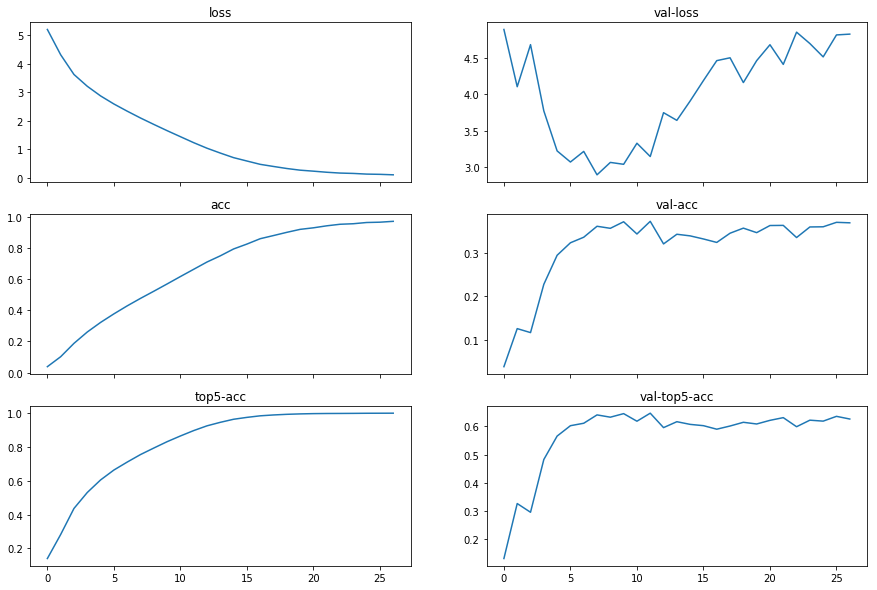

In [10]:
fig, ax = plt.subplots(3, 2, figsize=(15,10), sharex='col') # add parameter `sharey='row'` for a more direct comparison
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("acc")
ax[1, 1].set_title("val-acc")
ax[2, 0].set_title("top5-acc")
ax[2, 1].set_title("val-top5-acc")

ax[0, 0].plot(history.history['loss'])
ax[0, 1].plot(history.history['val_loss'])
ax[1, 0].plot(history.history['sparse_categorical_accuracy'])
ax[1, 1].plot(history.history['val_sparse_categorical_accuracy'])
ax[2, 0].plot(history.history['sparse_top_5_categorical_accuracy'])
ax[2, 1].plot(history.history['val_sparse_top_5_categorical_accuracy'])


In [12]:
best_val_acc = max(history.history['val_sparse_categorical_accuracy']) * 100
best_val_top5 = max(history.history['val_sparse_top_5_categorical_accuracy']) * 100

print('Best val acc:  {:2.2f}%'.format(best_val_acc))
print('Best val top5: {:2.2f}%'.format(best_val_top5))

Best val acc:  37.19%
Best val top5: 64.68%


Good news for our previous implementation: the performance of the curated Keras version of ResNet-50 is about the same! A ~65% top-5 accuracy is a decent score, given the high number of classes / low number of training images. In Chapter 4, we covered several methods which could be used to improve the performance at minimal costs, e.g.:

 - **Prediction averaging** over several images derived from the original input (c.f. _scale jittering_);
 - **Model averaging** by training other models (e.g., Inception, ResNet-18, etc.) and comparing/averaging their predictions for each input;
 - **Transfer learning**;
 - etc.
 
While we leave it to our readers to experiment with some of these methods by themselves, we will dedicate the next notebooks to transfer learning.